# Evaluation of Customer Switching Behavior between Prepaid Mobile Plans

### Abstract

One new trending feature of Smartphones is the support for E-SIM (Embedded Subscriber Identification Module) cards. These allow the user to simultaneously subscribe to multiple cellular providers while also supporting at most one physical SIM (Subscriber Identification Module) card. This feature allows customers to easily switch between providers and is especially useful for those who use prepaid plans which are popular in developing countries. A customer may have multiple providers and, at any point in time, can choose the provider with the most cost effective data plan. This means that cellular providers must consider soft-churn, where the consumer dynamically switches between multiple plans from multiple providers, in addition to the more traditional churn, where a consumer switches providers. This means that data pricing for such consumers must now be more personalized in order to be competitive and maximize profits. We determine the optimal personalized prepaid plan for such users, while providing a competitive advantage to the provider. Examples are provided to demonstrate the benefit, and numerical results corroborate our premise that personalized over traditional pricing plans can improve the revenue of the provider.

This notebook has the code developed to evaluate the switching behavior of customers, and produce the graphs shown under the Numerical Results section of the paper.

## Necessary Libraries 

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import category_encoders as ce
import seaborn as sns
from datetime import date, datetime
import matplotlib.pyplot as plt
import re #For Regex Operations

from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import make_interp_spline, BSpline

Populating the interactive namespace from numpy and matplotlib


## Relevant Fields Description

Note that some fields were removed to preserve anonymity of data <br />

    BUNDLEID             - Prepaid Plan Identifier [Changed to preserve anonymity]
    Duration             - Given Length of the Plan
    INITIALBALANCELIMIT  - Initial amount of data allowed in bytes
    Time_Taken           - Amount in days customer took upon completion of the plan
    Usage                - Amount of data in bytes that the customer used upon completion of the plan
    Bundle_Status        - If the bundle was expired or exhausted

## Functions

### Obtain Fraction X of Data Used for all users

In [2]:
def obtain_x(data_usage_eval):
    '''
    Calculates X for expired and exhausted prepaid plans for all users.
    If the plan is expired, X is the fraction of data used before expiration.
    If the plan is exhausted, X is the fraction of time taken over the duration.

    :param: data_usage_eval: Accepts the dataframe with the relevant data and fields. 
    :return: data_usage_eval: Dataframe with updated fields.
    '''
    
    # Insert Column X into the datafram
    # If headers do not exist, insert them   
    if not 'X' in data_usage_eval.columns:
        data_usage_eval.insert(loc=6, column='X', value=' ')

    # Calculate fraction X     
    for i in range(len(data_usage_eval)):
        if data_usage_eval.at[i, 'Bundle_Status'] == 'Bundle_Expired':
            data_usage_eval.at[i, 'X'] = data_usage_eval.at[i, 'Usage'] / data_usage_eval.at[i, 'INITIALBALANCELIMIT']
        elif data_usage_eval.at[i, 'Bundle_Status'] == 'Bundle_Exhausted':
            data_usage_eval.at[i, 'X'] = data_usage_eval.at[i, 'Time_Taken'] / data_usage_eval.at[i, 'Duration']

    data_usage_eval['X'] = pd.to_numeric(data_usage_eval['X'])
    
    return data_usage_eval

### Graph displaying the fraction of data used before expiration of a plan

In [3]:
def expired_x_graph_display(data_usage_eval):
    '''
    Displays the graph for the fraction of data used before expiration, 
    against the different plans from the provider.

    :param data_usage_eval: Accepts the dataframe with the relevant data and fields. 
    :output: Shows the graph
    '''
    
    # Get data for expired plans only
    exp_prepaid = data_usage_eval.loc[data_usage_eval['Bundle_Status'] == 'Bundle_Expired']
    
    # Group by the Bundle ID and get the mean of each field
    group_prepaid_mean = exp_prepaid.groupby(['BUNDLEID']).mean().reset_index()

    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    x = group_prepaid_mean.index
    y = group_prepaid_mean['X']

    ax = sns.barplot(x=x, y=y, data=group_prepaid_mean, palette="Blues_d")
    ax.set(xlabel='Different Prepaid Plans ', ylabel='Fraction of data used before expiration (x)')
    plt.show()

### Calculate Profits for Personalized and Traditional for different profit margins

In [4]:
def get_profit(kp_list, data_usage_eval):
    '''
    Obtains the profit for traditional and personalized plans based
    on the profit margin

    :param: data_usage_eval: Accepts the dataframe with the relevant data and fields. 
    :output: Saves the profits for exhausted and expired plans for both traditional and personalized, 
    this is done to calculate the profit ratios later on.
    '''
    
    exp_personalized = dict()
    exp_traditional = dict()
    exh_personalized = dict()
    exh_traditional = dict()

    # If headers do not exist, insert them    
    if not set(['Personalized_Profit','Traditional_Profit']).issubset(data_usage_eval.columns):
        data_usage_eval.insert(loc=7, column='Personalized_Profit', value=' ')
        data_usage_eval.insert(loc=8, column='Traditional_Profit', value=' ')

    # For each profit margin in the range of profit margins
    for kp in kp_list:
        print("Profit Margin: ", kp)
        margin = 1 / (1+kp)
        
        # As explained in the paper, 
        # if the fraction X is <= margin, a personalized profit is made
        # if X > margin, then a traditional profit is made.
        for i in range(len(data_usage_eval)):
            if data_usage_eval.at[i, 'X'] <= margin:
                # X * kp
                data_usage_eval.at[i, 'Personalized_Profit'] = np.multiply(data_usage_eval.at[i, 'X'], kp)
                data_usage_eval.at[i, 'Traditional_Profit'] = 0
            elif data_usage_eval.at[i, 'X'] > margin:
                # 1 - X
                data_usage_eval.at[i, 'Traditional_Profit'] = 1 - data_usage_eval.at[i, 'X']
                data_usage_eval.at[i, 'Personalized_Profit'] = 0

        data_usage_eval['Personalized_Profit'] = pd.to_numeric(data_usage_eval['Personalized_Profit'], errors='coerce')
        data_usage_eval['Traditional_Profit'] = pd.to_numeric(data_usage_eval['Traditional_Profit'], errors='coerce')

        # Separate expired and exhausted data
        expired = data_usage_eval.loc[data_usage_eval['Bundle_Status'] == 'Bundle_Expired']
        exhausted = data_usage_eval.loc[data_usage_eval['Bundle_Status'] == 'Bundle_Exhausted']
        
        # Sum the personalized and traditional profits calculated for expired plans
        exp_personalized[kp] = expired['Personalized_Profit'].sum()
        exp_traditional[kp] = expired['Traditional_Profit'].sum()
        
        # Sum the personalized and traditional profits calculated for expired plans
        exh_personalized[kp] = exhausted['Personalized_Profit'].sum()
        exh_traditional[kp] = exhausted['Traditional_Profit'].sum()
        
        print("Expired Personalized Profit: ", exp_personalized[kp])
        print("Expired Traditional Profit: ", exp_traditional[kp])
        print("Exhausted Personalized Profit: ", exh_personalized[kp])
        print("Exhausted Traditional Profit: ", exh_traditional[kp])
        print("\n")

    return exp_personalized, exp_traditional, exh_personalized, exh_traditional

### Get Profit Ratios 

In [5]:
def get_profit_ratios(kp_list, exp_personalized, exp_traditional, exh_personalized, exh_traditional):
    '''
    Calculates the profit ratios using the personalized and 
    traditonal profits previously calculated.

    :param: kp_list: Range of profit margins from 0.02 - 0.15
    :param: exp_personalized: Personalized profits for the range of profit margins [0.02 - 0.15] for expired fields. 
    :param: exp_traditional: Traditional profits for the range of profit margins [0.02 - 0.15] for exhausted fields. 
    :param: exh_personalized: Personalized profits for the range of profit margins [0.02 - 0.15] for expired fields. 
    :param: exh_traditional: Traditional profits for the range of profit margins [0.02 - 0.15] for exhausted fields.
    
    :return: exp_ratios: Expired Profit Ratios.
    :return: exp_pers_profits: Personalized Profits for Expired Plans.
    :return: exp_trad_profits: Traditional Profits for Expired Plans.
    :return: exh_ratios: Exhausted Profit Ratios.
    :return: exh_pers_profits: Personalized Profits for Exhausted Plans.
    :return: exh_trad_profits: Traditional Profits for Exhausted Plans.
    '''
    exp_pers_profits = []
    exp_trad_profits = []
    exh_pers_profits = []
    exh_trad_profits = []
    exp_ratio = []
    exh_ratio = []

    # Get profits and profit ratios for expired and exhausted plans
    for x in kp_list:
        # Personalized profits for expired plans
        exp_pers_profits.append(exp_personalized[x])
        # Traditional profits for expired plans
        exp_trad_profits.append(exp_traditional[x])
        # Personalized profits for exhausted plans
        exh_pers_profits.append(exh_personalized[x])
        # Traditional profits for exhausted plans
        exh_trad_profits.append(exh_traditional[x])

        # Profit ratios for expired plans
        exp_ratio.append(exp_personalized[x]/exp_traditional[x])
        # Profit ratios for exhausted plans
        exh_ratio.append(exh_personalized[x]/exh_traditional[x])
        
    # Expired Data
    exp_ratios = np.array(exp_ratio)
    exp_pers_profits = np.array(exp_pers_profits)
    exp_trad_profits = np.array(exp_trad_profits)

    # Exhausted Data
    exh_ratios = np.array(exh_ratio)
    exh_pers_profits = np.array(exh_pers_profits)
    exh_trad_profits = np.array(exh_trad_profits)
        
    return exp_ratios, exp_pers_profits, exp_trad_profits, exh_ratios, exh_pers_profits, exh_trad_profits

### Produce Profit Ratio Graphs

In [6]:
def profit_ratio_graph(kp_list, ratio, personalized, traditional):
    '''
    Calculates the profit ratios using the personalized and 
    traditonal profits previously calculated.

    :param: kp_list: Range of profit margins from 0.02 - 0.15
    :param: ratio: Profit Ratios Previously Calculated
    :param: personalized: Personalized Profits
    :param: traditional: Traditional Profits
    
    :output: Profit Ratio Graph

    '''
    # Profit Margins     
    kp = np.array(kp_list)
    
    # Range of profit margin from min to max
    xnew = np.linspace(kp.min(), kp.max(), 3000)
    
    # Profit Ratios
    a_BSpline = make_interp_spline(kp, ratio)
    
    # Personalized Profits
    pers_BSpline = make_interp_spline(kp, personalized)
    
    # Traditional Profits
    trad_BSpline = make_interp_spline(kp, traditional)
    
    y_new = a_BSpline(xnew)
    y_pers = pers_BSpline(xnew)
    y_trad = trad_BSpline(xnew)

    # Set the x axis label
    plt.xlabel('Profit Margin (kp)')
    # Set the y axis label
    plt.ylabel('Profit Ratio (G)')
    
    # Plot the graph
    plt.plot(xnew, y_new)
    plt.show()

## Call All Functions Here

### Read CSV

In [7]:
data_usage_eval = pd.read_csv('data_usage.csv')

# Display first 5 rows
data_usage_eval.head()

,BUNDLEID,Usage,Time_Taken,INITIALBALANCELIMIT,Duration,Bundle_Status
0,2797,4.096000e+04,6.176481,26843545600,7,Bundle_Expired
1,3045,4.096000e+04,1.394502,104857600,2,Bundle_Expired
2,2828,2.308096e+07,1.249931,26843545600,7,Bundle_Expired
3,2831,3.975373e+08,28.754190,42949672960,30,Bundle_Expired
4,2831,3.221484e+09,28.558067,42949672960,30,Bundle_Expired


### Get X

In [8]:
data_usage_eval = obtain_x(data_usage_eval)
data_usage_eval.head()

,BUNDLEID,Usage,Time_Taken,INITIALBALANCELIMIT,Duration,Bundle_Status,X
0,2797,4.096000e+04,6.176481,26843545600,7,Bundle_Expired,0.000002
1,3045,4.096000e+04,1.394502,104857600,2,Bundle_Expired,0.000391
2,2828,2.308096e+07,1.249931,26843545600,7,Bundle_Expired,0.000860
3,2831,3.975373e+08,28.754190,42949672960,30,Bundle_Expired,0.009256
4,2831,3.221484e+09,28.558067,42949672960,30,Bundle_Expired,0.075006


### Graph Displaying Average fraction of data usage used before expiration for 20 actual plans

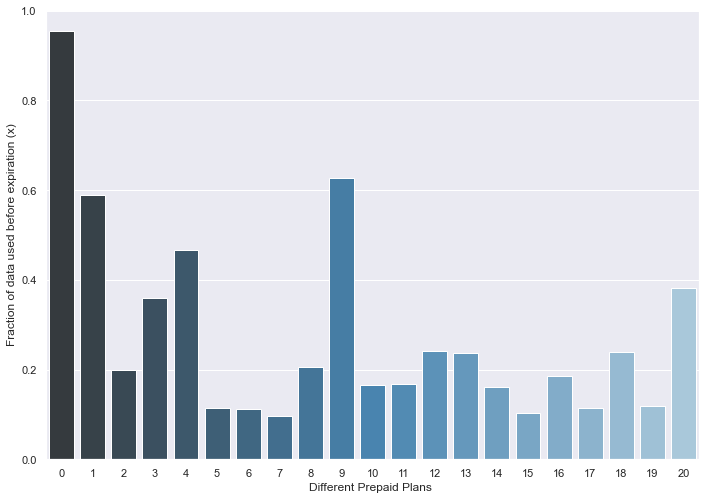

In [9]:
expired_x_graph_display(data_usage_eval)

### Store New Data to Calculate Profit Ratios

In [10]:
# kp for 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.15
kp_list = [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.15]

# Save profits for personalized and traditional plans
exp_personalized, exp_traditional, exh_personalized, exh_traditional = get_profit(kp_list, data_usage_eval)

Profit Margin:  0.02
Expired Personalized Profit:  1377.09222057376
Expired Traditional Profit:  13.823270943911401
Exhausted Personalized Profit:  108.79780439263668
Exhausted Traditional Profit:  3.493768573633159


Profit Margin:  0.04
Expired Personalized Profit:  2711.8203155749975
Expired Traditional Profit:  45.720131630849366
Exhausted Personalized Profit:  206.4854178064374
Exhausted Traditional Profit:  11.738994102733686


Profit Margin:  0.06
Expired Personalized Profit:  3960.999311992811
Expired Traditional Profit:  133.86744213609984
Exhausted Personalized Profit:  297.32393903108465
Exhausted Traditional Profit:  22.00253279320988


Profit Margin:  0.08
Expired Personalized Profit:  5241.9291371970785
Expired Traditional Profit:  168.32645721941284
Exhausted Personalized Profit:  379.15506704144616
Exhausted Traditional Profit:  37.04188695987655


Profit Margin:  0.1
Expired Personalized Profit:  6503.2389981606375
Expired Traditional Profit:  212.60222386230126
Exhaus

### Get Profit Ratios 

In [11]:
exp_ratios, exp_pers_profits, exp_trad_profits, exh_ratios, exh_pers_profits, exh_trad_profits = get_profit_ratios(kp_list, exp_personalized, exp_traditional, exh_personalized, exh_traditional)

### Produce Graphs

#### Profit Ratio Graph for Expired Plans

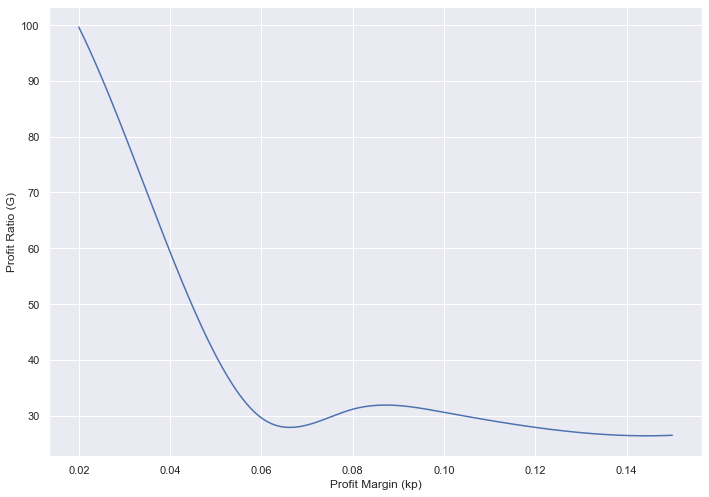

In [12]:
profit_ratio_graph(kp_list, exp_ratios, exp_pers_profits, exp_trad_profits)

#### Profit Ratio Graph for Exhausted Plans

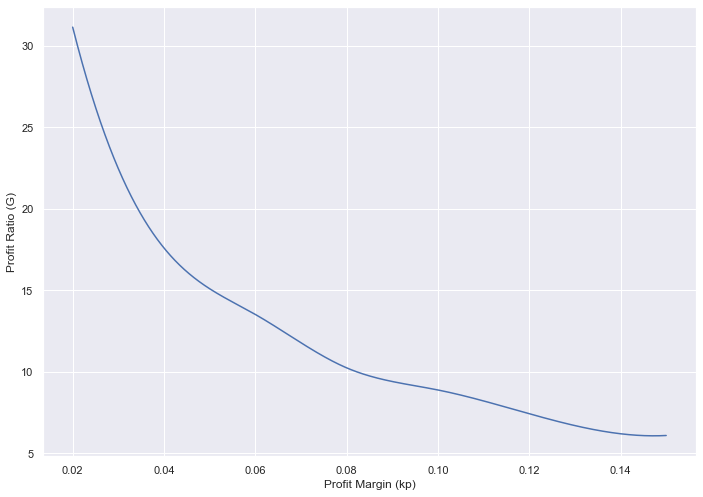

In [13]:
profit_ratio_graph(kp_list, exh_ratios, exh_pers_profits, exh_trad_profits)

The results demonstrate the same relationship found within the illustrative example. As the profit margin for the personalized plan decreases, the per customer profit also decreases. However, more customers are attracted to the provider with personalized plans due to a cheaper cost and thus, less customers remain on the traditional plan, leading to a larger profit ratio. Analysis on expired plans revealed that the profit ratio was larger than exhausted plans, with values ranging from 26 to 100, proving that these customers tend to benefit more. The profit ratio for exhausted plans were still high, ranging from 6 to 31, showing the effectiveness that personalized plans can have on profit optimisation and customer benefits. 